# Adjoint Optimization Demo

In this tutorial notebook, we will use the `tidy3d.adjoint` plugin to demonstrate the inverse design of a lens using the principles outlined in the previous [lectures](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/).

The main documentation for the `adjoint` plugin can be found [here](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/AdjointPlugin1Intro.html) as well as a handful of demos of adjoint optimization in action, such as for desigining a [grating coupler](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/AdjointPlugin6GratingCoupler.html) or a [mode converter](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/AdjointPlugin3InverseDesign.html).

## Set Up

First, we will set up the basic parameters of our simulation. We will define a 2D simulation domain with a central design region consisting of a grid of rectangular regions where we may vary the relative permittivity between that of vacuum and that of our lens material. Using the adjoint plugin, we compute the gradient of the lens focusing with respect to the permittivity of each grid cell. Then we use this gradient to update the grid cell permittivities in the direction of maximizing focusing strength. This process is repeated until a final design is achieved.

In [ ]:

import matplotlib.pylab as plt
import numpy as np
import tidy3d as td

# in addition to the regular tidy3d package, we also import the adjoint plugin
# this gives us special tidy3d components that track derivative information
import tidy3d.plugins.adjoint as tda

# we also import the web run function from the adjoint plugin, which lets us use the adjoint plugin
# on the server side to compute gradient information efficiently
from tidy3d.plugins.adjoint.web import run_local as run

# for the rest of the process, we use the "jax" package to define our objective function
# and take derivatives using automatic differentiation
import jax
import jax.numpy as jnp


In [ ]:
# source info
wavelength = 1.0
freq0 = td.C_0 / wavelength
fwidth = freq0 / 10
run_time = 100 / fwidth

# geometry into
lens_thick = 1.5575563445 * wavelength
lens_width = 5.575563445 * wavelength
dist = 2.3 * wavelength
buffer = 1.0 * wavelength

# simulation size
Lx = lens_thick + 2 * buffer + 2 * dist
Ly = lens_width + 2 * buffer
Lz = 0.0

# material information
ref_ind_lens = 1.5
eps_lens = ref_ind_lens ** 2

# lens discretization
nx = 33
ny = 93

dl = wavelength/20

MNT_NAME_FOCUS = "focus"
MNT_NAME_FIELD = "field"

In [ ]:
# minimal thickness
min_thick = dist * (np.sqrt(1 + (lens_width/2/dist)) - 1)
print(f'minimum thickness should be {(min_thick/wavelength):.2f} wavelengths')

minimum thickness should be 1.12 wavelengths


Next, we will define the source and field monitor components for our simulation.

In [ ]:
source = td.PointDipole(
    center=(-lens_thick/2 - dist, 0, 0),
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth,
    ),
    polarization="Ez",
)

fld_mnt = td.FieldMonitor(
    center=(0,0,0),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name=MNT_NAME_FIELD,
)

focus_mnt = td.FieldMonitor(
    center=(lens_thick/2 + dist, 0, 0),
    size=(0, 0, 0),
    freqs=[freq0],
    name=MNT_NAME_FOCUS,
    fields = ["Ez"]
)

Next, we write a function to generate the `JaxCustomMedium` structure that defines our lens as a pixellated grid as a function of an array grid permittivity values. We also write a function generate the `JaxSimulation` from the same inputs. Separating these as functions makes it easier to organize our code for taking derivatives later.

In [ ]:
def make_lens(eps_array: jnp.array) -> tda.JaxStructure:
    """Make a lens structure out of the grid permittivity values (nx, ny)."""

    # define data coordinates
    dx = lens_thick / nx
    dy = lens_width / ny

    xmin = - lens_thick / 2.0 + dx / 2.0
    ymin = - lens_width / 2.0 + dy / 2.0

    xs = [xmin + index_x * dx - 1e-5 for index_x in range(nx)]
    ys = [ymin + index_y * dy - 1e-5 for index_y in range(ny)]


    coords = dict(
        x=xs,
        y=ys,
        z=[0.],
        f=[freq0],
    )

    data = eps_array.reshape((nx, ny, 1, 1))

    eps_components = {}
    for dim in "xyz":
        key = f"eps_{dim}{dim}"
        sclr_fld = tda.JaxDataArray(values=data, coords=coords)
        eps_components[key] = sclr_fld

    eps_dataset = tda.JaxPermittivityDataset(**eps_components)
    custom_medium = tda.JaxCustomMedium(eps_dataset=eps_dataset, subpixel=False)

    geometry = tda.JaxBox(
        center=(0,0,0),
        size=(lens_thick, lens_width,  td.inf)
    )

    return tda.JaxStructure(
        geometry=geometry,
        medium=custom_medium
    )

In [ ]:
def make_sim(eps_array: jnp.array, incl_fld_mnt: bool = False) -> tda.JaxSimulation:
    """Make a simulation containing the custom lens grid."""

    lens = make_lens(eps_array)
    monitors = [fld_mnt] if incl_fld_mnt else []

    # quick notes: the lens is differentiable, so it goes in input_structures
    # also, we are differentiating with respect to the focus monitor output,
    # so that goes in output_monitors

    return tda.JaxSimulation(
        size=(Lx, Ly, Lz),
        run_time=run_time,
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
        grid_spec=td.GridSpec.uniform(dl=dl),
        input_structures=[lens],
        output_monitors=[focus_mnt],
        sources=[source],
        monitors=monitors,
    )

Let's make a simulation using some random starting values and make sure it looks ok.

In [ ]:
rand_arr = np.random.random((nx, ny))
rand_arr_sym_y = (rand_arr + rand_arr[:, ::-1])/2.0

EPS_ARRAY = (eps_lens - 1) * rand_arr_sym_y + 1

sim = make_sim(EPS_ARRAY)

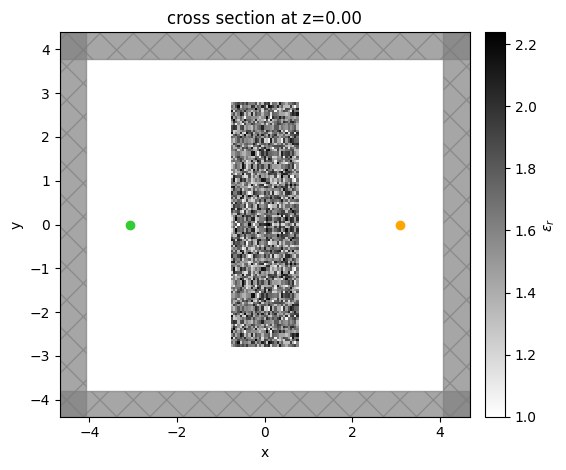

In [ ]:
ax = sim.plot_eps(z=0)

## Objective Function

Now that we have a function that generates our simulation given an array of our permittivity values, we are ready to set up our objective function for optimization. Like before, we will write this as a function over the array of permittivity values and will try to split up the logical steps as well as possible for clarity.

First, we will write a function that maps an array of parameters with values between -infinity and infinity to permittivity values between 1 and the permittivity of our lens material. This is done to ensure that we never extend outside of these values when optimizing later.

In [ ]:
from tidy3d.plugins.adjoint.utils.filter import ConicFilter, BinaryProjector

def params_to_eps(params: jnp.array) -> jnp.array:
    """Map an array of parameters with infinity extent to an array of permittivity values within bounds."""

    params_between_0_1 = 0.5 * (jnp.tanh(params) + 1.0)

#     conic_filter = ConicFilter(feature_size=0.3, design_region_dl=dl)
    binary_projector = BinaryProjector(vmin=1.0, vmax=eps_lens, beta=1.0)

#     eps_values = binary_projector.evaluate(conic_filter.evaluate(params_between_0_1.reshape((nx, ny))).reshape((nx, ny, 1, 1)))

    eps_values = binary_projector.evaluate(params_between_0_1)

    return eps_values

def measure_intensity(sim_data: tda.JaxSimulationData) -> float:
    """Return the intensity at the focal spot as a function of the data from the solver."""
    focal_fields = sim_data[MNT_NAME_FOCUS]
    intensity = 0.0
    for key in focal_fields.monitor.fields:
        field = focal_fields.field_components[key]
        intensity += jnp.sum(jnp.abs(jnp.array(field.values))**2)
    return intensity

def objective_fn(params: jnp.array, verbose:bool = False, incl_fld_mnt: bool = True) -> float:
    """Run the full calculation from setting up sim, running, and measuring intensity."""
    eps_data = params_to_eps(params)
    sim = make_sim(eps_data, incl_fld_mnt=incl_fld_mnt)
    sim_data = run(sim, task_name="lens_adjoint", verbose=verbose, path='data/lens_adjoint.hdf5')
    return measure_intensity(sim_data), sim_data

Let's use jax to get a function that returns our objective funciton value and its gradient with respect to the eps_data array to veritfy this works as expected.

In [ ]:
# feed in an array of very small parameters, corresponding to vacuum simulation
params_empty = -1000 * np.ones((nx, ny))
val_and_grad_fn = jax.value_and_grad(objective_fn, has_aux=True)

In [ ]:
(val_empty, sim_data), grad_empty = val_and_grad_fn(params_empty, verbose=True)

print(f"value = {val_empty}")
print(f"grad = {grad_empty}")

[14:16:28] Created task 'lens_adjoint_fwd' with task_id                                               ]8;id=698039;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=697904;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#189\189]8;;\
           'fdve-70e38201-1ae1-40f5-8af2-b6ec54c3b5bcv1'.                                                          

           View task using web UI at                                                                  ]8;id=224396;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=711992;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#191\191]8;;\
           ]8;id=161980;https://tidy3d.simulation.cloud/workbench?taskId=fdve-70e38201-1ae1-40f5-8af2-b6ec54c3b5bcv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=231680;https://tidy3d.simulation.cloud/workbench?taskId=fdve-70e38201-1ae1-40f5-8af2-b6ec54c3b5bcv1\taskId]8;;\]8;id=161980;https://tidy3d.simulation.cloud/workbench?taskId=fdve-70e38201-1ae1-40f5-8af2-b6ec54c3b5bcv1\=]8;;\]8;id=294577;https://tidy3d.simulation.cloud/workbench?taskId=fdve-70e38201-1ae1-40f5-8af2-b6ec54c3b5bcv1\fdve]8;;\]8;id=161980;https://tidy3d.simulation.cloud/workbench?taskId=fdve-70e38201-1ae1-40f5-8af2-b6ec54c3b5bcv1\-70e38201-1ae1-40f5-8af2-b6ec54c3b5b]8;;\              
           ]8;id=161980;https://tidy3d.simulation.cloud/workbench?taskId=fdve-70e38201-1ae1-40f5-8af2-b6ec54c3b5bcv1\cv1']8;;\.                                                                                                   

Output()

Output()

[14:16:31] status = queued                                                                            ]8;id=353545;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=279226;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#363\363]8;;\

Output()

[14:16:35] status = preprocess                                                                        ]8;id=801417;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=774246;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

[14:16:41] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=332040;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=595063;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=204375;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=485037;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#379\379]8;;\

           running solver                                                                             ]8;id=497068;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=853110;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#388\388]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or 'web.delete(task_id)' or             ]8;id=627545;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=371571;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#389\389]8;;\
           abort/delete the task in the web UI. Terminating the Python script will not stop the job                
           running on the cloud.                                                                                   

Output()

[14:16:48] status = postprocess                                                                       ]8;id=941024;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=839217;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#421\421]8;;\

Output()

[14:16:55] status = success                                                                           ]8;id=611912;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=373318;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#428\428]8;;\

Output()

[14:16:57] loading SimulationData from data/lens_adjoint.hdf5                                         ]8;id=746045;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=263043;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#606\606]8;;\

[14:16:58] Created task 'lens_adjoint_adj' with task_id                                               ]8;id=645210;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=128168;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#189\189]8;;\
           'fdve-fcfb4628-6d93-41b0-ab95-165656be92b8v1'.                                                          

           View task using web UI at                                                                  ]8;id=510222;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=411032;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#191\191]8;;\
           ]8;id=724374;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fcfb4628-6d93-41b0-ab95-165656be92b8v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=310483;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fcfb4628-6d93-41b0-ab95-165656be92b8v1\taskId]8;;\]8;id=724374;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fcfb4628-6d93-41b0-ab95-165656be92b8v1\=]8;;\]8;id=54800;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fcfb4628-6d93-41b0-ab95-165656be92b8v1\fdve]8;;\]8;id=724374;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fcfb4628-6d93-41b0-ab95-165656be92b8v1\-fcfb4628-6d93-41b0-ab95-165656be92b]8;;\              
           ]8;id=724374;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fcfb4628-6d93-41b0-ab95-165656be92b8v1\8v1']8;;\.                                                                                                   

Output()

Output()

[14:17:01] status = queued                                                                            ]8;id=654094;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=306347;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#363\363]8;;\

Output()

[14:17:05] status = preprocess                                                                        ]8;id=666989;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=60880;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

[14:17:10] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=100278;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=802949;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=525973;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=315248;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#379\379]8;;\

           running solver                                                                             ]8;id=458324;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=800351;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#388\388]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or 'web.delete(task_id)' or             ]8;id=373304;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=910979;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#389\389]8;;\
           abort/delete the task in the web UI. Terminating the Python script will not stop the job                
           running on the cloud.                                                                                   

Output()

[14:17:17] early shutoff detected, exiting.                                                           ]8;id=537894;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=226459;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#406\406]8;;\

           status = postprocess                                                                       ]8;id=743454;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=155410;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#421\421]8;;\

Output()

[14:17:22] status = success                                                                           ]8;id=969294;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=479289;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#428\428]8;;\

Output()

[14:17:23] loading SimulationData from data/lens_adjoint.hdf5                                         ]8;id=646734;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=725460;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#606\606]8;;\

value = 2287817.0
grad = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Normalize Objective function

Let's quickly make an objective function that is normalized by this value without a structure, so we have a dimensionless objective function that represents the "enhancement" of the intensity with respect to vacuum.

In [ ]:
def objective_fn_normalized(params: jnp.array, verbose:bool = False, incl_fld_mnt: bool = True) -> float:
    """Run the full calculation from setting up sim, running, and measuring intensity, normalized to vacuum result."""
    val_orig, aux_data = objective_fn(params, verbose=verbose, incl_fld_mnt=incl_fld_mnt)
    return val_orig / val_empty, aux_data

In [ ]:
# get the val and grad function with normalization
val_and_grad_fn_normalized = jax.value_and_grad(objective_fn_normalized, has_aux=True)

We will start our optimization with parameters slightly lower than the middle of the two permittivity limits.

In [ ]:
PARAMS0 = -0.1 * np.ones((nx, ny))



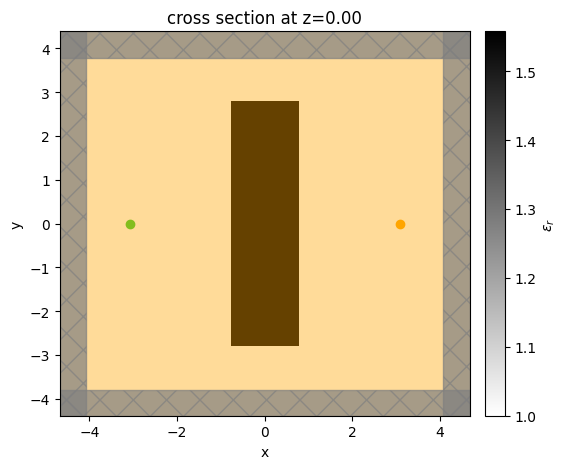

In [ ]:
sim_initial = make_sim(params_to_eps(PARAMS0), incl_fld_mnt=True)
sim_initial.plot_eps(z=0)
plt.show()

In [ ]:
sim_data_initial = run(sim_initial, task_name="lens_initial", path='data/lens_initial.hdf5')

[14:17:24] Created task 'lens_initial' with task_id 'fdve-de0f2f2d-c430-4053-a272-89c6569c3cfav1'.    ]8;id=664519;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=434619;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#189\189]8;;\

           View task using web UI at                                                                  ]8;id=739777;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=991030;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#191\191]8;;\
           ]8;id=982973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-de0f2f2d-c430-4053-a272-89c6569c3cfav1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=984747;https://tidy3d.simulation.cloud/workbench?taskId=fdve-de0f2f2d-c430-4053-a272-89c6569c3cfav1\taskId]8;;\]8;id=982973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-de0f2f2d-c430-4053-a272-89c6569c3cfav1\=]8;;\]8;id=374533;https://tidy3d.simulation.cloud/workbench?taskId=fdve-de0f2f2d-c430-4053-a272-89c6569c3cfav1\fdve]8;;\]8;id=982973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-de0f2f2d-c430-4053-a272-89c6569c3cfav1\-de0f2f2d-c430-4053-a272-89c6569c3cf]8;;\              
           ]8;id=982973;https://tidy3d.simulation.cloud/workbench?taskId=fdve-de0f2f2d-c430-4053-a272-89c6569c3cfav1\av1']8;;\.                                                                                                   

Output()

Output()

[14:17:27] status = queued                                                                            ]8;id=905124;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=494379;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#363\363]8;;\

Output()

[14:17:31] status = preprocess                                                                        ]8;id=726504;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=77514;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

[14:17:36] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=844225;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=275210;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=65753;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=770606;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#379\379]8;;\

           running solver                                                                             ]8;id=442110;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=493622;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#388\388]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or 'web.delete(task_id)' or             ]8;id=586220;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=660898;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#389\389]8;;\
           abort/delete the task in the web UI. Terminating the Python script will not stop the job                
           running on the cloud.                                                                                   

Output()

[14:17:43] status = postprocess                                                                       ]8;id=83920;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=14973;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#421\421]8;;\

Output()

[14:17:50] status = success                                                                           ]8;id=352377;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=388033;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#428\428]8;;\

Output()

[14:17:51] loading SimulationData from data/lens_initial.hdf5                                         ]8;id=514061;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=536014;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#606\606]8;;\

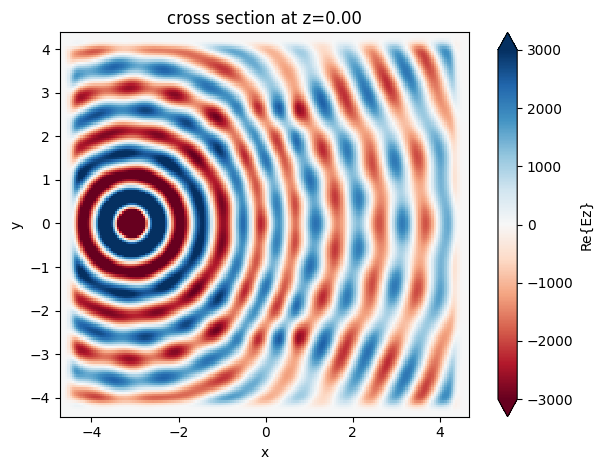

In [ ]:
ax = sim_data_initial.plot_field(MNT_NAME_FIELD, 'Ez', 'real')

In [ ]:
# get the starting objective function value
val0 = measure_intensity(sim_data_initial) / val_empty

In [ ]:
val0

Array(1.9754281, dtype=float32)

## Optimization

Now that we have our objective and gradient function defined, we can perform a simple optimization of our parameters.

We will just perform a simple "gradient ascent" algorithm in which we compute the gradient, perturb each of the parameters simultaneously in the direction that maximizes the objective function, and repeat this process several times until convergence.

In [ ]:
# how many iterations
num_steps = 35

# magnitude of the update to the parameters in units of the gradient.
step_size = 1
step_size = 0.03

In [ ]:
import optax

optimizer = optax.adam(learning_rate=step_size, b1=0.0, b2=0.0)

params_i = PARAMS0.copy()
eps_i = params_to_eps(params_i)
sim_i = make_sim(eps_i, incl_fld_mnt=True)

opt_state = optimizer.init(params_i)

# lists to store the values and parameters
param_vals = []
obj_fn_vals = []
grad_norm_vals = []
sims = [sim_i]
sim_datas = [sim_data_initial]

for i in range(num_steps):
    print(f'step = {i + 1}')

    # compute gradient
    (val_i, sim_data_i), grad_i = val_and_grad_fn_normalized(params_i)

    # update
    updates, opt_state = optimizer.update(-grad_i, opt_state, params_i)
    params_i = optax.apply_updates(params_i, updates)

    grad_norm_i = jnp.linalg.norm(grad_i)

    # print status
    print(f'\tval = {val_i:.3e}')
    print(f'\tnorm(grad) = {grad_norm_i:.3e}')

    # store history
    obj_fn_vals.append(val_i)
    param_vals.append(params_i.copy())
    grad_norm_vals.append(grad_norm_i)

    eps_i = params_to_eps(params_i)
    sim_i = make_sim(eps_i, incl_fld_mnt=True)
    sims.append(sim_i)
    sim_datas.append(sim_data_i)


step = 1
	val = 1.975e+00
	norm(grad) = 1.846e-01
step = 2
	val = 2.534e+00
	norm(grad) = 2.052e-01
step = 3
	val = 3.147e+00
	norm(grad) = 2.230e-01
step = 4
	val = 3.805e+00
	norm(grad) = 2.377e-01
step = 5
	val = 4.497e+00
	norm(grad) = 2.492e-01
step = 6
	val = 5.213e+00
	norm(grad) = 2.569e-01
step = 7
	val = 5.938e+00
	norm(grad) = 2.612e-01
step = 8
	val = 6.661e+00
	norm(grad) = 2.625e-01
step = 9
	val = 7.369e+00
	norm(grad) = 2.612e-01
step = 10
	val = 8.058e+00
	norm(grad) = 2.585e-01
step = 11
	val = 8.725e+00
	norm(grad) = 2.550e-01
step = 12
	val = 9.367e+00
	norm(grad) = 2.505e-01
step = 13
	val = 9.988e+00
	norm(grad) = 2.453e-01
step = 14
	val = 1.058e+01
	norm(grad) = 2.389e-01
step = 15
	val = 1.115e+01
	norm(grad) = 2.313e-01
step = 16
	val = 1.170e+01
	norm(grad) = 2.234e-01
step = 17
	val = 1.221e+01
	norm(grad) = 2.140e-01
step = 18
	val = 1.268e+01
	norm(grad) = 2.055e-01
step = 19
	val = 1.313e+01
	norm(grad) = 1.951e-01
step = 20
	val = 1.354e+01
	norm(grad) =

Let's visualize the optimization results and the final fields!

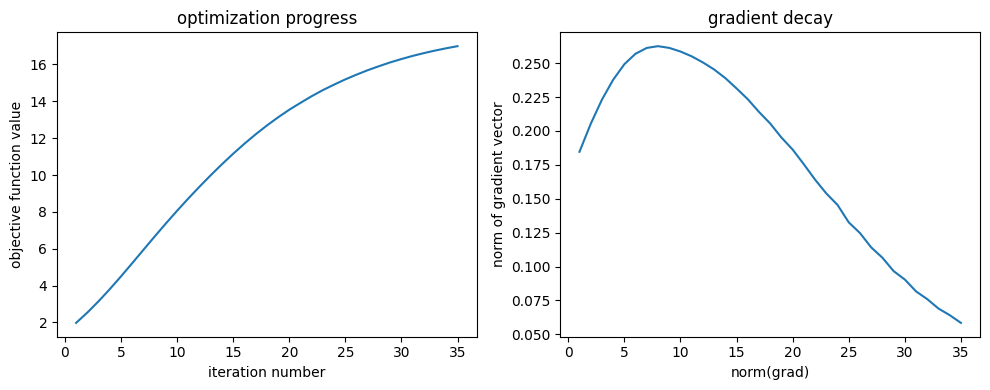

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))

iters = np.arange(1, len(obj_fn_vals) + 1)

ax1.plot(iters, obj_fn_vals)
ax1.set_xlabel('iteration number')
ax1.set_ylabel('objective function value')
ax1.set_title('optimization progress')

ax2.plot(iters, grad_norm_vals)
ax2.set_xlabel('norm(grad)')
ax2.set_ylabel('norm of gradient vector')
ax2.set_title('gradient decay')

plt.show()

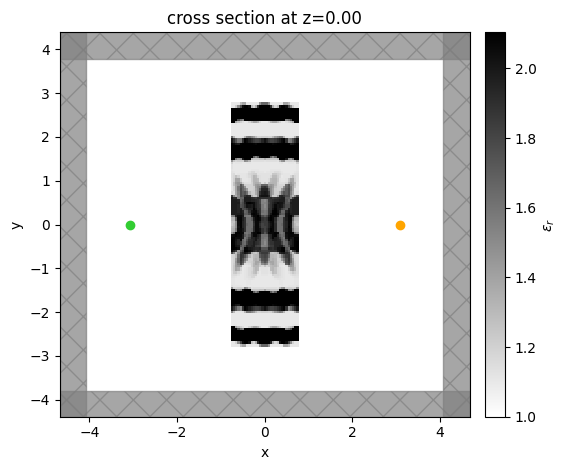

In [ ]:
params_final = param_vals[-1]
sim_final = make_sim(params_to_eps(params_final), incl_fld_mnt=True)
ax = sim_final.plot_eps(z=0, monitor_alpha=0.0)

In [ ]:
sim_data_final = run(sim_final, task_name="lens_final", path='data/lens_final.hdf5')

[14:59:57] Created task 'lens_final' with task_id 'fdve-1d12301f-668a-462b-82d5-45d819cf54dav1'.      ]8;id=930779;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=494968;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#189\189]8;;\

           View task using web UI at                                                                  ]8;id=573784;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=787105;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#191\191]8;;\
           ]8;id=135394;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d12301f-668a-462b-82d5-45d819cf54dav1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=798852;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d12301f-668a-462b-82d5-45d819cf54dav1\taskId]8;;\]8;id=135394;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d12301f-668a-462b-82d5-45d819cf54dav1\=]8;;\]8;id=988635;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d12301f-668a-462b-82d5-45d819cf54dav1\fdve]8;;\]8;id=135394;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d12301f-668a-462b-82d5-45d819cf54dav1\-1d12301f-668a-462b-82d5-45d819cf54d]8;;\              
           ]8;id=135394;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1d12301f-668a-462b-82d5-45d819cf54dav1\av1']8;;\.                                                                                                   

Output()

Output()

[14:59:59] status = queued                                                                            ]8;id=342121;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=702985;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#363\363]8;;\

Output()

[15:00:03] status = preprocess                                                                        ]8;id=833055;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=406878;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

[15:00:07] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=582951;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=771214;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=873975;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=777206;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#379\379]8;;\

           running solver                                                                             ]8;id=354519;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=200911;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#388\388]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or 'web.delete(task_id)' or             ]8;id=955080;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=642553;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#389\389]8;;\
           abort/delete the task in the web UI. Terminating the Python script will not stop the job                
           running on the cloud.                                                                                   

Output()

[15:00:13] early shutoff detected, exiting.                                                           ]8;id=168833;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=750820;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#406\406]8;;\

           status = postprocess                                                                       ]8;id=54795;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=792358;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#421\421]8;;\

Output()

[15:00:18] status = success                                                                           ]8;id=143055;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=367821;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#428\428]8;;\

Output()

[15:00:19] loading SimulationData from data/lens_final.hdf5                                           ]8;id=174974;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=16467;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#606\606]8;;\

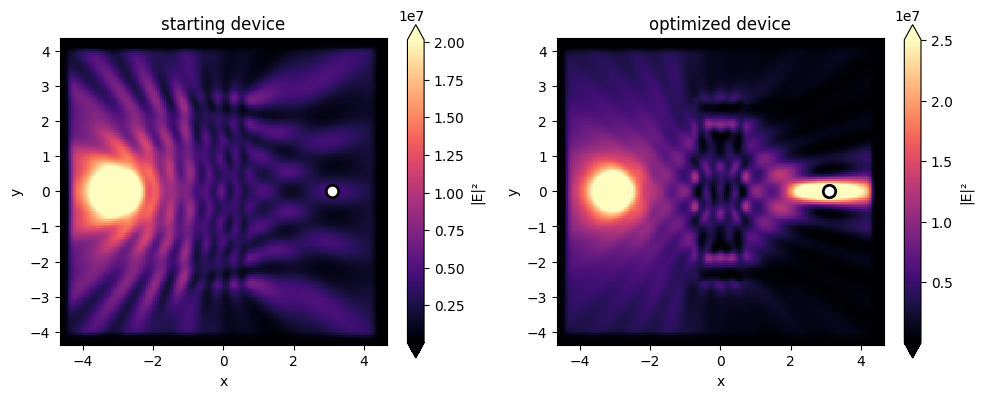

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))

sim_data_initial.plot_field('field', 'E', 'abs^2', ax=ax1)
sim_data_final.plot_field('field', 'E', 'abs^2', ax=ax2)

x_meas, y_meas = list(focus_mnt.center)[:2]

ax1.scatter(x_meas, y_meas, s=80, c="white", linewidth=2.0, edgecolor='black')
ax2.scatter(x_meas, y_meas, s=80, c="white", linewidth=2.0, edgecolor='black')

ax1.set_title('starting device')
ax2.set_title('optimized device')

plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, (ax_eps, ax_ez, ax_int) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))

def animate(i):
    sim_i = sims[i]
    sim_data_i = sim_datas[i]

    sim_i = sim_i.updated_copy(structures=list(sim_i.structures) + [td.Structure(geometry=td.Box(size=(0.001,0.001,0.1), center=focus_mnt.center), medium=td.Medium(permittivity=eps_lens))])
    sim_i.plot_eps(z=0, monitor_alpha=0.0, ax=ax_eps)
    sim_data_i[MNT_NAME_FIELD].Ez.real.squeeze().plot.pcolormesh(x='x', y='y', ax=ax_ez, add_colorbar=False)
    sim_data_i.get_intensity(MNT_NAME_FIELD).real.squeeze().plot.pcolormesh(x='x', y='y', ax=ax_int, add_colorbar=False, cmap="magma", vmax=0.3e8)#, aspect="equal")

# create animation
ani = animation.FuncAnimation(fig, animate, frames=len(sims));
plt.close()

# display the animation
HTML(ani.to_jshtml())


<Figure size 640x480 with 0 Axes>

In [ ]:
ani.save('animation_basic.gif', writer='imagemagick', fps=60)

MovieWriter imagemagick unavailable; using Pillow instead.


<Figure size 640x480 with 0 Axes>